# **Loading Dataset to Google Colab**

In [ ]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ast
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV

# Load dataset
df = pd.read_csv('https://docs.google.com/uc?export=download&id=14CZBR0p358hjSolZLTUtMk5LCel7QeCG')
df.head() # prints the first 5 rows of the dataframe

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,8,afrocaribean.com is a source for tips related ...,"{""id"":361,""name"":""Web"",""slug"":""journalism/web""...",272,DE,Germany,1483712826,"{""id"":1780495357,""name"":""Sariah (deleted)"",""is...",EUR,€,False,USD,1485104400,False,NaN,1.174965,3300.0,1384162778,NaN,False,NaN,1484739103,"{""id"":646099,""name"":""Dusseldorf"",""slug"":""dusse...","afrocaribean.com: Food, travel & work with gus...",NaN,"{""key"":""assets/015/119/070/ebafcf66c2dc63b4202...",255.0,"{""id"":2824261,""project_id"":2824261,""state"":""in...",afrocaribeancom-food-travel-and-work-with-gusto,https://www.kickstarter.com/discover/categorie...,False,False,canceled,1485098531,1.064015,"{""web"":{""project"":""https://www.kickstarter.com...",271.323932,domestic
1,0,"A vodcast focused on celebrating the ideation,...","{""id"":361,""name"":""Web"",""slug"":""journalism/web""...",0,US,the United States,1425355021,"{""id"":196230387,""name"":""Scott Kitun"",""slug"":""n...",USD,$,True,USD,1439395077,False,NaN,1.000000,15000.0,1900051537,NaN,False,NaN,1436803077,"{""id"":2379574,""name"":""Chicago"",""slug"":""chicago...",Tomorrow's Business Today (Canceled),NaN,"{""key"":""assets/012/056/655/8c9348595b5ddc5f3a2...",0.0,"{""id"":1744636,""project_id"":1744636,""state"":""in...",tomorrows-business-today,https://www.kickstarter.com/discover/categorie...,False,False,canceled,1437062910,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",0.000000,domestic
2,1,"Nuestro objetivo es crear el bot más completo,...","{""id"":51,""name"":""Software"",""slug"":""technology/...",1,ES,Spain,1590363606,"{""id"":860289387,""name"":""Manchadito"",""slug"":""ma...",EUR,€,False,USD,1595888978,False,NaN,1.174965,300.0,1896196945,NaN,False,NaN,1590704978,"{""id"":766273,""name"":""Madrid"",""slug"":""madrid-ma...",ManchaBot,NaN,"{""key"":""assets/029/206/874/446376cd3cb767e631d...",1.0,"{""id"":4001204,""project_id"":4001204,""state"":""in...",manchabot,https://www.kickstarter.com/discover/categorie...,False,False,failed,1595888978,1.096215,"{""web"":{""project"":""https://www.kickstarter.com...",1.096215,domestic
3,27,A singer-songwriter who doesn't sell CDs and f...,"{""id"":44,""name"":""World Music"",""slug"":""music/wo...",2556,US,the United States,1272733648,"{""id"":1005247063,""name"":""Kray Van Kirk (delete...",USD,$,True,USD,1278187200,False,NaN,1.000000,2500.0,1475818961,NaN,False,NaN,1275430660,"{""id"":2430300,""name"":""Juneau"",""slug"":""juneau-a...","Music without borders, music without cost.",NaN,"{""key"":""assets/011/261/857/160a9fc5b1b93e97f67...",2556.0,"{""id"":5700,""project_id"":5700,""state"":""inactive...",music-without-borders-music-without-cost,https://www.kickstarter.com/discover/categorie...,True,False,successful,1278187209,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2556.000000,international
4,28,Jump start the Summer Season of our company's ...,"{""id"":24,""name"":""Performance Art"",""slug"":""art/...",3081,US,the United States,1302034474,"{""id"":75728883,""name"":""Rafael Moreno"",""slug"":""...",USD,$,True,USD,1304632834,False,NaN,1.000000,3000.0,1188585937,NaN,False,NaN,1302040834,"{""id"":12589342,""name"":""Manhattan"",""slug"":""manh...","You, Construct, The Future.",NaN,"{""key"":""assets/011/281/946/fd6e400002b5ee23069...",3081.0,"{""id"":29494,""project_id"":29494,""state"":""inacti...",you-construct-the-future,https://www.kickstarter.com/discover/categorie...,True,False,successful,1304632835,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3081.000000,domestic


In [ ]:
print(len(df))

3697


# **Cleaning the dataset**

In [ ]:
# Remove unnecessary features.
cols_to_keep = ["backers_count", "blurb", "category", "country", "created_at", "currency", "deadline", "goal", "name", "spotlight", "staff_pick", "state", "usd_pledged"]
df_new = df.filter(cols_to_keep)

# Remove all rows containing a 'live' state.
df_new = df_new.drop(df_new[df_new['state'] == 'live'].index)
df_new = df_new.drop(df_new[df_new['state'] == 'canceled'].index)
df_new.reset_index(drop=True, inplace=True)

# Change the 'blurb' column to contain the lengths of each blurb.
blurbs = df_new["blurb"]
blurb_lengths = []

for blurb in blurbs:
  blurb_lengths.append(len(blurb))

# Change the 'name' column to contain the lengths of each name.
names = df_new["name"]
name_lengths = []

for name in names:
  name.replace("(Canceled)", "")
  name_lengths.append(len(name))

# Calculate the deadlines of each project in days and append it to the dataframe.
duration = []

start = df_new["created_at"]
end = df_new["deadline"]

for i in range(len(end)):
  duration.append(round((end[i] - start[i])/60/60/24))

# Find the appropriate category from the dictionary of category attributes
# provided by the dataset.
categories = df_new["category"]
category_names = []

for category in categories:
  if 'parent_name' in ast.literal_eval(category):
      category_names.append(ast.literal_eval(category)["parent_name"])
  else:
    category_names.append(ast.literal_eval(category)["name"])

# Change the categorical spotlight value into a binary value.
binary_spotlight = []
spotlight = df_new['spotlight']

for item in spotlight:
  if (item == True):
      binary_spotlight.append(1)
  else:
      binary_spotlight.append(0)

# Change the categorical staffPick value into a binary value.
binary_staffPick = []
staffPick = df_new['staff_pick']

for item in staffPick:
  if (item == True):
      binary_staffPick.append(1)
  else:
      binary_staffPick.append(0)

# Change the categorical state value into a binary value. Assuming that the
# 'failed' and 'canceled states are identical.
binary_state = []
state = df_new['state']

for item in state:
  if (item == 'successful'):
      binary_state.append(1)
  else:
      binary_state.append(0)

# Assign all the new values to the dataframe.
df_new["blurb"] = blurb_lengths
df_new["name"] = name_lengths
df_new["duration"] = duration
df_new["category"] = category_names
df_new["spotlight"] = binary_spotlight
df_new["staff_pick"] = binary_staffPick
df_new["state"] = binary_state

# Change the names of 'blurb' and 'name' columns.
df_new = df_new.rename(columns={"blurb":"blurb_length", "name":"name_length"})

# Drop 'created_at' since it is not needed anymore, after creating 'deadline'.
df_new = df_new.drop(columns = "created_at")
df_new = df_new.drop(columns = "deadline")
df_new = df_new.drop(columns = "spotlight")
df_new = df_new.drop(columns = 'currency')
df_new = df_new.drop(columns = 'country')

# Create dummy variables for 'category' and 'country'.
df_test = pd.get_dummies(df_new, columns=['category'])
#df_test = pd.get_dummies(df_test, columns=['country'])
#df_test = pd.get_dummies(df_test, columns=['currency'])

df_test

,backers_count,blurb_length,goal,name_length,staff_pick,state,usd_pledged,duration,category_Art,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film & Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater
0,1,84,300.0,9,0,0,1.096215,64.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,27,144,2500.0,42,0,1,2556.000000,63.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,28,129,3000.0,27,0,1,3081.000000,30.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36,135,10000.0,43,0,1,11710.000000,22.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,6,122,4800.0,6,0,0,314.000000,25.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,46,123,2000.0,15,1,1,2662.283633,34.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3430,73,132,20000.0,8,0,1,20649.420000,152.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3431,0,135,150.0,13,0,0,0.000000,34.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3432,6,122,2000.0,59,0,1,321.073958,41.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test.state.describe()

count    3434.000000
mean        0.605416
std         0.488832
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: state, dtype: float64

In [ ]:
def make_histogram(dataframe, column_name):
  dataframe.hist(column = column_name)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7e1eec630>]],
      dtype=object)

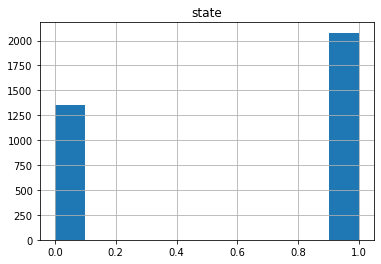

In [ ]:
df_test.hist(column='state')

#**Building and testing the model**

In [ ]:
corrMatrix = df_test.corr()
corrMatrix

,backers_count,blurb_length,goal,name_length,staff_pick,state,usd_pledged,duration,category_Art,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film & Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater
backers_count,1.000000,0.018463,0.194568,0.051233,0.131461,0.147341,0.872264,0.034213,-0.044555,0.014710,-0.031342,-0.009810,0.074386,-0.015593,-0.040964,-0.035539,0.137030,-0.024606,-0.039003,-0.014939,-0.011498,0.103417,-0.020669
blurb_length,0.018463,1.000000,0.022699,0.195176,0.038755,-0.051585,0.013671,0.001866,-0.063305,-0.018641,-0.049202,0.053551,0.008598,-0.087045,0.023051,0.045934,-0.033724,0.065504,0.026745,0.026410,-0.006536,-0.000189,0.044463
goal,0.194568,0.022699,1.000000,-0.024852,0.024126,-0.027937,0.158227,0.005205,0.034792,-0.008906,-0.009574,-0.007508,-0.006078,-0.011479,-0.008480,0.005341,0.047596,-0.006948,-0.016525,-0.007986,-0.011166,0.001337,-0.008165
name_length,0.051233,0.195176,-0.024852,1.000000,0.036064,0.119176,0.072424,0.056597,-0.008494,-0.000664,-0.006554,0.001797,0.020498,0.027570,-0.159375,0.009787,0.016092,-0.023056,0.033961,-0.004375,0.011759,0.095267,0.006100
staff_pick,0.131461,0.038755,0.024126,0.036064,1.000000,0.231274,0.150223,0.071882,-0.039194,0.064425,-0.003392,0.043803,-0.017188,-0.051174,0.013989,-0.008197,0.021743,0.025919,-0.049824,0.034740,0.039978,-0.019514,0.023958
state,0.147341,-0.051585,-0.027937,0.119176,0.231274,1.000000,0.145598,0.055681,0.007300,0.117443,-0.026925,0.084315,-0.042519,0.030903,-0.032721,-0.139912,0.114349,-0.075234,0.081900,-0.044472,0.010946,-0.111217,0.065005
usd_pledged,0.872264,0.013671,0.158227,0.072424,0.150223,0.145598,1.000000,0.028069,-0.047128,-0.007635,-0.033698,-0.012943,0.065432,-0.008067,-0.038328,-0.022445,0.083706,-0.026326,-0.043636,-0.014532,-0.019443,0.162644,-0.018981
duration,0.034213,0.001866,0.005205,0.056597,0.071882,0.055681,0.028069,1.000000,-0.025895,0.005972,-0.022026,-0.036382,0.008973,-0.007209,-0.014750,0.010433,0.051463,0.031771,0.014596,-0.019186,-0.014073,0.035102,-0.039096
category_Art,-0.044555,-0.063305,0.034792,-0.008494,-0.039194,0.007300,-0.047128,-0.025895,1.000000,-0.073517,-0.076232,-0.060048,-0.058048,-0.097236,-0.131981,-0.115335,-0.090656,-0.068989,-0.149316,-0.065419,-0.092276,-0.114940,-0.067817
category_Comics,0.014710,-0.018641,-0.008906,-0.000664,0.064425,0.117443,-0.007635,0.005972,-0.073517,1.000000,-0.043743,-0.034456,-0.033309,-0.055795,-0.075732,-0.066181,-0.052019,-0.039587,-0.085679,-0.037538,-0.052949,-0.065954,-0.038914


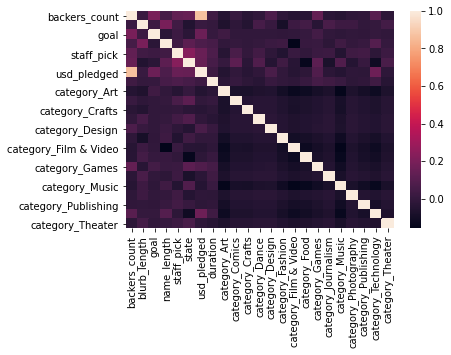

In [ ]:
sns.heatmap(corrMatrix, annot=False)
plt.show()

In [ ]:
corr_pairs = corrMatrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]

print(strong_pairs)

backers_count          usd_pledged              0.872264
usd_pledged            backers_count            0.872264
backers_count          backers_count            1.000000
category_Dance         category_Dance           1.000000
category_Publishing    category_Publishing      1.000000
blurb_length           blurb_length             1.000000
goal                   goal                     1.000000
name_length            name_length              1.000000
staff_pick             staff_pick               1.000000
state                  state                    1.000000
usd_pledged            usd_pledged              1.000000
duration               duration                 1.000000
category_Art           category_Art             1.000000
category_Technology    category_Technology      1.000000
category_Comics        category_Comics          1.000000
category_Design        category_Design          1.000000
category_Fashion       category_Fashion         1.000000
category_Film & Video  category

# **NEW DATASET**

In [ ]:
# Remove unnecessary features.
cols_to_keep = ["backers_count", "blurb", "category", "country", "created_at", "currency", "deadline", "goal", "name", "spotlight", "staff_pick", "state", "usd_pledged"]
df_new = df.filter(cols_to_keep)

# Remove all rows containing a 'live' state.
df_new = df_new.drop(df_new[df_new['state'] == 'live'].index)
df_new = df_new.drop(df_new[df_new['state'] == 'canceled'].index)
df_new.reset_index(drop=True, inplace=True)

# Change the 'blurb' column to contain the lengths of each blurb.
blurbs = df_new["blurb"]
blurb_lengths = []

for blurb in blurbs:
  blurb_lengths.append(len(blurb))

# Change the 'name' column to contain the lengths of each name.
names = df_new["name"]
name_lengths = []

for name in names:
  name.replace("(Canceled)", "")
  name_lengths.append(len(name))

# Calculate the deadlines of each project in days and append it to the dataframe.
duration = []

start = df_new["created_at"]
end = df_new["deadline"]

for i in range(len(end)):
  duration.append(round((end[i] - start[i])/60/60/24))

# Find the appropriate category from the dictionary of category attributes
# provided by the dataset.
categories = df_new["category"]
category_names = []

for category in categories:
  if 'parent_name' in ast.literal_eval(category):
      category_names.append(ast.literal_eval(category)["parent_name"])
  else:
    category_names.append(ast.literal_eval(category)["name"])

# Change the categorical spotlight value into a binary value.
binary_spotlight = []
spotlight = df_new['spotlight']

for item in spotlight:
  if (item == True):
      binary_spotlight.append(1)
  else:
      binary_spotlight.append(0)

# Change the categorical staffPick value into a binary value.
binary_staffPick = []
staffPick = df_new['staff_pick']

for item in staffPick:
  if (item == True):
      binary_staffPick.append(1)
  else:
      binary_staffPick.append(0)

# Change the categorical state value into a binary value. Assuming that the
# 'failed' and 'canceled states are identical.
binary_state = []
state = df_new['state']

for item in state:
  if (item == 'successful'):
      binary_state.append(1)
  else:
      binary_state.append(0)

usdPledged = df_new['usd_pledged']
goal = df_new['goal']
percentGoal = []

for idx in range(len(usdPledged)):
  percentGoal.append(usdPledged[idx] / goal[idx])

# Assign all the new values to the dataframe.
df_new["blurb"] = blurb_lengths
df_new["name"] = name_lengths
df_new["duration"] = duration
df_new["category"] = category_names
df_new["spotlight"] = binary_spotlight
df_new["staff_pick"] = binary_staffPick
df_new["state"] = binary_state
#df_new["percentGoal"] = percentGoal

# Change the names of 'blurb' and 'name' columns.
df_new = df_new.rename(columns={"blurb":"blurb_length", "name":"name_length"})

# Drop 'created_at' since it is not needed anymore, after creating 'deadline'.
df_new = df_new.drop(columns = "created_at")
df_new = df_new.drop(columns = "deadline")
df_new = df_new.drop(columns = "spotlight")
df_new = df_new.drop(columns = 'currency')
df_new = df_new.drop(columns = 'country')
df_new = df_new.drop(columns = "usd_pledged")
df_new = df_new.drop(columns = "backers_count")
#df_new = df_new.drop(columns = "goal")

# Create dummy variables for 'category' and 'country'.
df_test = pd.get_dummies(df_new, columns=['category'])
#df_test = pd.get_dummies(df_test, columns=['country'])
#df_test = pd.get_dummies(df_test, columns=['currency'])

df_test

,blurb_length,goal,name_length,staff_pick,state,duration,category_Art,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film & Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater
0,84,300.0,9,0,0,64.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,144,2500.0,42,0,1,63.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,129,3000.0,27,0,1,30.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,135,10000.0,43,0,1,22.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,122,4800.0,6,0,0,25.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,123,2000.0,15,1,1,34.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3430,132,20000.0,8,0,1,152.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3431,135,150.0,13,0,0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3432,122,2000.0,59,0,1,41.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_art = df_test
df_art = df_art.drop(df_art.index[df_test.index[df_test["category_Art"] == 0].tolist()])
num = df_art.value_counts("state")[1]
den = df_art.value_counts("state")[1] + df_art.value_counts("state")[0]
p = num/den
print("Percent success of art: " + str(p))

Percent success of art: 0.6153846153846154


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_test.drop('state',1), df_test['state'], test_size=0.30, random_state=0)

In [ ]:
def fit_and_score_model(mdl, X_train, X_test, y_train, y_test, random_state=0):
    """
    This function will fit and score the input mdl to the X_train and y_train
    data, and score the mdl on y_train and y_test. To ensure results are
    reproducible we can also set a random state.
    """

    # Fit an arbitrary model
    mdl.fit(X_train, y_train)

    # Calculate the score of the model on training and testing data
    train_score = mdl.score(X_train, y_train)
    test_score = mdl.score(X_test, y_test)

    # Print scores to terminal
    print('the accuracy on the: \n\t training data is {}'.format(round(train_score,3)))
    print('\t testing data is {}'.format(round(test_score, 3)))

    return train_score, test_score

In [ ]:
# Initialize cross validation score DataFrame
depth_lb = 1
depth_ub = 21
cv_scores = pd.Series(index=np.arange(depth_lb, depth_ub), dtype=float)

for max_depth in range(depth_lb, depth_ub):

  # Initialize the model
  rf_cv1_model = RandomForestClassifier(random_state = 0, max_depth = max_depth, max_features = 'auto')

  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, X_train, y_train, cv=5)

  # Record the average out-of-sample error
  cv_scores.loc[max_depth] = example_cv_results['test_score'].mean()

print("Completed")

Completed


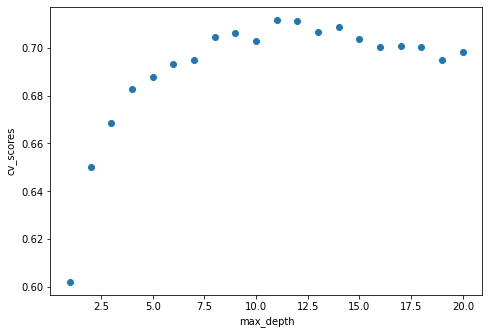

In [ ]:
depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(depth, cv_scores)
ax.set_xlabel('max_depth')
ax.set_ylabel('cv_scores')
plt.show()

In [ ]:
cv_scores

1     0.602164
2     0.650014
3     0.668742
4     0.682892
5     0.687892
6     0.693306
7     0.694969
8     0.704541
9     0.706207
10    0.702885
11    0.711623
12    0.711204
13    0.706622
14    0.708704
15    0.703708
16    0.700377
17    0.700798
18    0.700378
19    0.694967
20    0.698293
dtype: float64

In [ ]:
mdl = RandomForestClassifier(n_estimators = 50, max_depth = 17, bootstrap = True, random_state = 0, max_samples = 0.2)
print('For max depth 17 ', end ='')
train, test = fit_and_score_model(mdl, X_train, X_test, y_train, y_test)

For max depth 17 the accuracy on the: 
	 training data is 0.831
	 testing data is 0.712


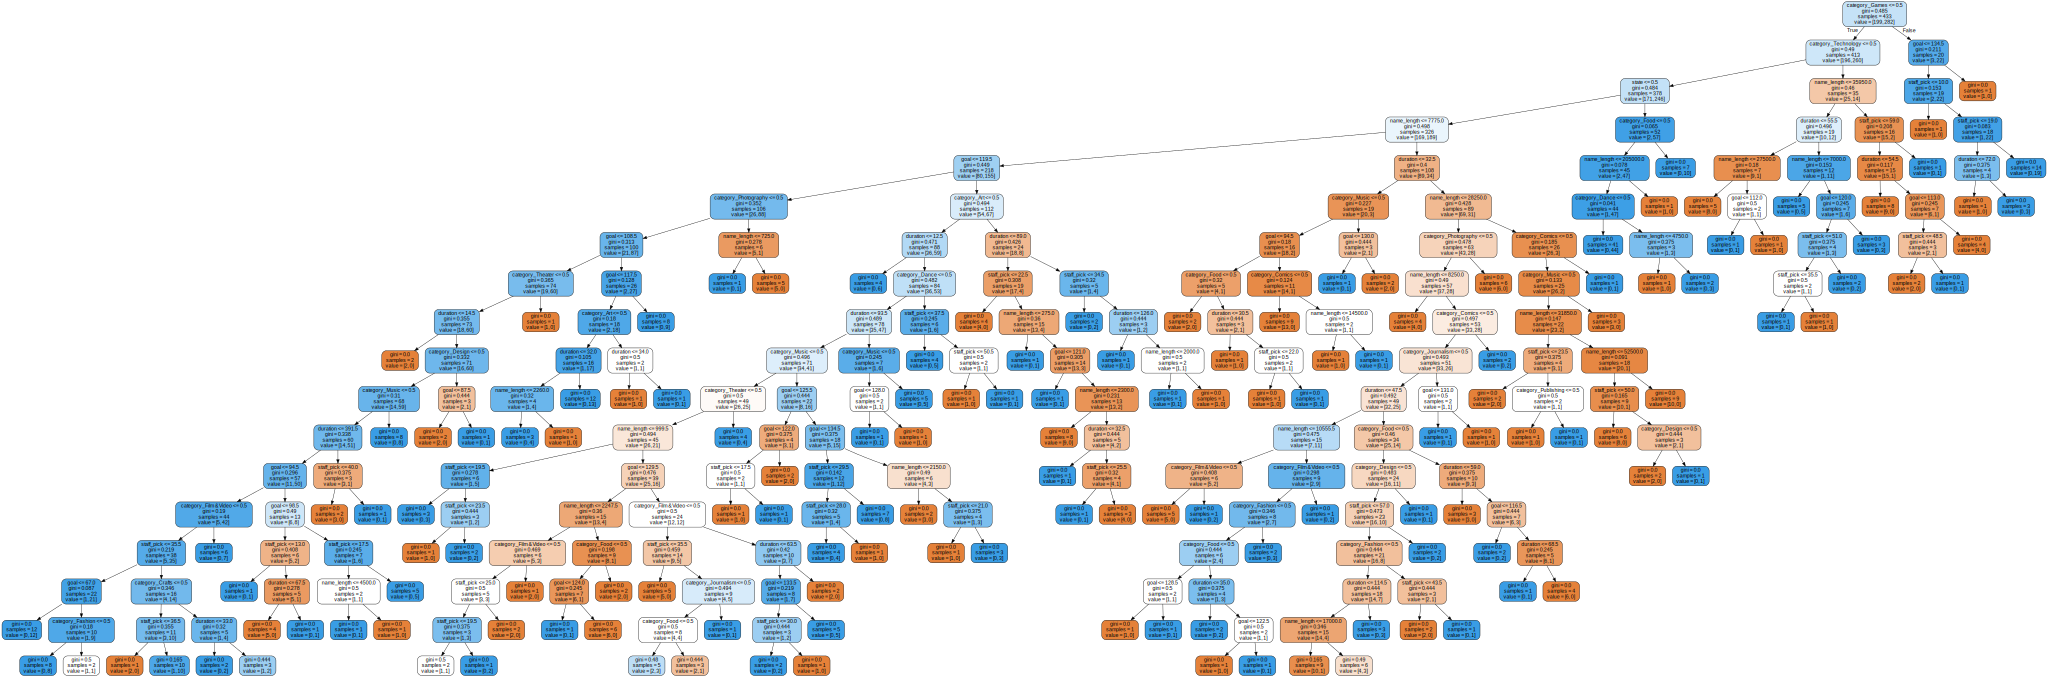

In [ ]:
mdl.estimators_[0]

cart_graph = Source(export_graphviz(mdl.estimators_[1],
                   feature_names = df_test.columns[1:],
                   rounded = True, proportion = False,
                  filled = True))
SVG(cart_graph.pipe(format='svg'))

In [ ]:
mdl.predict_proba(X_test)[:,1]

array([0.74060606, 0.68410606, 0.06      , ..., 0.2512437 , 0.89025641,
       0.56001736])

In [ ]:
X_test.reset_index(inplace = True, drop = True)
X_test.head

<bound method NDFrame.head of       blurb_length      goal  ...  category_Technology  category_Theater
0              112     500.0  ...                    0                 0
1               66     500.0  ...                    0                 1
2              130  150000.0  ...                    1                 0
3              127    3000.0  ...                    0                 0
4              134   70000.0  ...                    0                 0
...            ...       ...  ...                  ...               ...
1026           135   30000.0  ...                    0                 0
1027           123    5000.0  ...                    0                 0
1028           134   16500.0  ...                    0                 0
1029            61    1240.0  ...                    0                 0
1030            41    5500.0  ...                    0                 0

[1031 rows x 20 columns]>

In [ ]:
X_test.iloc[1]

blurb_length              66.0
goal                     500.0
name_length               29.0
staff_pick                 0.0
duration                  60.0
category_Art               0.0
category_Comics            0.0
category_Crafts            0.0
category_Dance             0.0
category_Design            0.0
category_Fashion           0.0
category_Film & Video      0.0
category_Food              0.0
category_Games             0.0
category_Journalism        0.0
category_Music             0.0
category_Photography       0.0
category_Publishing        0.0
category_Technology        0.0
category_Theater           1.0
Name: 1, dtype: float64

In [ ]:
mdl.predict_proba(X_test)[:,1]

array([0.74060606, 0.68410606, 0.06      , ..., 0.2512437 , 0.89025641,
       0.56001736])

In [ ]:
X = pd.DataFrame([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
X
#mdl.predict()

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,0


In [ ]:
X_trial=df_test.drop(columns='state').head()
print(X_trial)

   blurb_length     goal  ...  category_Technology  category_Theater
0            84    300.0  ...                    1                 0
1           144   2500.0  ...                    0                 0
2           129   3000.0  ...                    0                 0
3           135  10000.0  ...                    0                 0
4           122   4800.0  ...                    0                 0

[5 rows x 20 columns]


In [ ]:
mdl.predict_proba(X_trial)

array([[0.44      , 0.56      ],
       [0.24769505, 0.75230495],
       [0.54937707, 0.45062293],
       [0.4509234 , 0.5490766 ],
       [0.5463208 , 0.4536792 ]])

In [ ]:
mdl.predict_proba(X_trial)[:,1]

array([0.56      , 0.75230495, 0.45062293, 0.5490766 , 0.4536792 ])

In [ ]:
mdl.classes_

array([0, 1])

#**User Profiles**

In [ ]:
#the catagories of projcts
catagories = [ "Art", "Comics", "Craft", "Dance", "Design", "Fashion",
              "Film&Video", "Food", "Games", "Jornalisim", "Music", "Photography", "Publishing", "Technology", "Theater" ]
#the user profiles we made
user1 = pd.Series([0   ,  0.1,  0.1,  0.1, 0.05, 0.2,    0,    0, 0.05, 0.2, 0.15, 0.5,   0,    0,    0])
user2 = pd.Series([0.05,  0.1,    0,    0,    0,   0,  0.1,    0,  0.2,   0, 0.05,   0,   0,  0.5,    0])
user3 = pd.Series([0.05,	0.05,	0.05,	0.05,	0.05, 	0, 0.15, 0.15,	  0, 	 0,	   0,	  0, 0.1,	0.45,	0.05])
#convert into a data frame
users = pd.DataFrame([list(user1), list(user2), list(user3)], columns = catagories)

users

,Art,Comics,Craft,Dance,Design,Fashion,Film&Video,Food,Games,Jornalisim,Music,Photography,Publishing,Technology,Theater
0,0.00,0.10,0.10,0.10,0.05,0.2,0.00,0.00,0.05,0.2,0.15,0.5,0.0,0.00,0.00
1,0.05,0.10,0.00,0.00,0.00,0.0,0.10,0.00,0.20,0.0,0.05,0.0,0.0,0.50,0.00
2,0.05,0.05,0.05,0.05,0.05,0.0,0.15,0.15,0.00,0.0,0.00,0.0,0.1,0.45,0.05


#**Model 2 - "Fresh" Projects**

In [ ]:
# Remove unnecessary features.
cols_to_keep2 = ["backers_count", "blurb", "category", "country", "created_at", "currency", "deadline", "goal", "name", "spotlight", "staff_pick", "state", "usd_pledged"]
df_new2 = df.filter(cols_to_keep2)

# Remove all rows containing a 'live' state.
df_new2 = df_new2.drop(df_new2[df_new2['state'] == 'live'].index)
df_new2 = df_new2.drop(df_new2[df_new2['state'] == 'canceled'].index)
df_new2.reset_index(drop=True, inplace=True)

# Change the 'blurb' column to contain the lengths of each blurb.
blurbs2 = df_new2["blurb"]
blurb_lengths2 = []

for blurb in blurbs2:
  blurb_lengths2.append(len(blurb))

# Change the 'name' column to contain the lengths of each name.
names2 = df_new2["name"]
name_lengths2 = []

for name in names2:
  names2.replace("(Canceled)", "")
  name_lengths2.append(len(name))

# Calculate the deadlines of each project in days and append it to the dataframe.
duration2 = []

start2 = df_new2["created_at"]
end2 = df_new2["deadline"]

for i in range(len(end2)):
  duration2.append(round((end2[i] - start2[i])/60/60/24))

# Find the appropriate category from the dictionary of category attributes
# provided by the dataset.
categories2 = df_new2["category"]
category_names2 = []

for category in categories2:
  if 'parent_name' in ast.literal_eval(category):
      category_names2.append(ast.literal_eval(category)["parent_name"])
  else:
    category_names2.append(ast.literal_eval(category)["name"])

# Change the categorical spotlight value into a binary value.
binary_spotlight2 = []
spotlight2 = df_new2['spotlight']

for item in spotlight2:
  if (item == True):
      binary_spotlight2.append(1)
  else:
      binary_spotlight2.append(0)

# Change the categorical staffPick value into a binary value.
binary_staffPick2 = []
staffPick2 = df_new2['staff_pick']

for item in staffPick2:
  if (item == True):
      binary_staffPick2.append(1)
  else:
      binary_staffPick2.append(0)

# Change the categorical state value into a binary value. Assuming that the
# 'failed' and 'canceled states are identical.
binary_state2 = []
state2 = df_new2['state']

for item in state2:
  if (item == 'successful'):
      binary_state2.append(1)
  else:
      binary_state2.append(0)

usdPledged2 = df_new2['usd_pledged']
goal2 = df_new2['goal']
percentGoal2 = []

for idx in range(len(usdPledged2)):
  percentGoal2.append(usdPledged2[idx] / goal2[idx])

# Assign all the new values to the dataframe.
df_new2["blurb"] = blurb_lengths2
df_new2["name"] = name_lengths2
df_new2["duration"] = duration2
df_new2["category"] = category_names2
df_new2["spotlight"] = binary_spotlight2
df_new2["staff_pick"] = binary_staffPick2
df_new2["state"] = binary_state2
#df_new["percentGoal"] = percentGoal

# Change the names of 'blurb' and 'name' columns.
df_new2 = df_new2.rename(columns={"blurb":"blurb_length", "name":"name_length"})

# Drop 'created_at' since it is not needed anymore, after creating 'deadline'.
df_new2 = df_new2.drop(columns = "created_at")
df_new2 = df_new2.drop(columns = "deadline")
df_new2 = df_new2.drop(columns = "spotlight")
df_new2 = df_new2.drop(columns = 'currency')
df_new2 = df_new2.drop(columns = 'country')
#df_new2 = df_new2.drop(columns = "usd_pledged")
#df_new2 = df_new2.drop(columns = "backers_count")
#df_new2 = df_new2.drop(columns = "goal")

# Create dummy variables for 'category' and 'country'.
df_test2 = pd.get_dummies(df_new2, columns=['category'])
#df_test = pd.get_dummies(df_test, columns=['country'])
#df_test = pd.get_dummies(df_test, columns=['currency'])

df_test2


,backers_count,blurb_length,goal,name_length,staff_pick,state,usd_pledged,duration,category_Art,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film & Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater
0,1,84,300.0,9,0,0,1.096215,64.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,27,144,2500.0,42,0,1,2556.000000,63.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,28,129,3000.0,27,0,1,3081.000000,30.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36,135,10000.0,43,0,1,11710.000000,22.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,6,122,4800.0,6,0,0,314.000000,25.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3429,46,123,2000.0,15,1,1,2662.283633,34.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3430,73,132,20000.0,8,0,1,20649.420000,152.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3431,0,135,150.0,13,0,0,0.000000,34.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3432,6,122,2000.0,59,0,1,321.073958,41.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Get the shape of the dataframe for when the usd pledged is equal to 0; 0 usd pledged implies 0 backers
zero_usd = df_test2["usd_pledged"] == 0
df_test2 = df_test2[zero_usd]
df_test2 = df_test2.drop(columns = "usd_pledged")
df_test2 = df_test2.drop(columns = "backers_count")

df_test2

,blurb_length,goal,name_length,staff_pick,state,duration,category_Art,category_Comics,category_Crafts,category_Dance,category_Design,category_Fashion,category_Film & Video,category_Food,category_Games,category_Journalism,category_Music,category_Photography,category_Publishing,category_Technology,category_Theater
14,103,7174.0,44,0,0,54.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
16,131,2000.0,5,0,0,343.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
34,28,35000.0,10,0,0,30.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
36,129,25000.0,7,0,0,33.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
42,125,345.0,31,0,0,30.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,130,1500.0,54,0,0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3401,119,1900.0,54,0,0,60.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3403,132,250.0,47,0,0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3406,17,800.0,13,0,0,26.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_test2.drop('state',1), df_test2['state'], test_size=0.30, random_state=0)

In [ ]:
# Initialize cross validation score DataFrame
depth_lb2 = 1
depth_ub2 = 21
cv_scores2 = pd.Series(index=np.arange(depth_lb2, depth_ub2), dtype=float)

for max_depth in range(depth_lb2, depth_ub2):

  # Initialize the model
  rf_cv1_model2 = RandomForestClassifier(random_state = 0, max_depth = max_depth, max_features = 'auto')

  # Run cross validation to get measure of out-of-sample error
  example_cv_results2 = cross_validate(rf_cv1_model2, X_train2, y_train2, cv=5)

  # Record the average out-of-sample error
  cv_scores2.loc[max_depth] = example_cv_results2['test_score'].mean()

print("Completed")

Completed


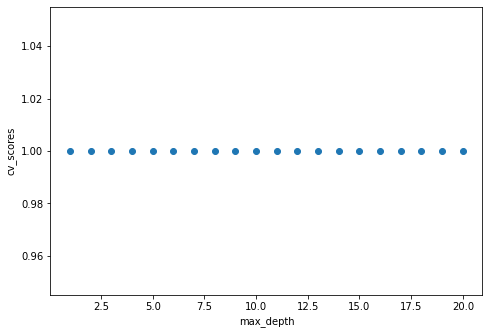

In [ ]:
depth2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

fig2 = plt.figure()
ax2=fig2.add_axes([0,0,1,1])
ax2.scatter(depth2, cv_scores2)
ax2.set_xlabel('max_depth')
ax2.set_ylabel('cv_scores')
plt.show()

In [ ]:
cv_scores2

1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
dtype: float64

In [ ]:
mdl2 = RandomForestClassifier(n_estimators = 50, max_depth = 17, bootstrap = True, random_state = 0, max_samples = 0.2)
print('For max depth 17 ', end ='')
train2, test2 = fit_and_score_model(mdl2, X_train2, X_test2, y_train2, y_test2)

For max depth 17 the accuracy on the: 
	 training data is 1.0
	 testing data is 1.0


In [ ]:
mdl2.predict.proba()